In [1]:
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
import time
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

## 1 测试集的trace去训练集里面寻找
## 2根据第一条记录(真正的出发点去寻找)

In [2]:
#港口坐标数据
#港口坐标数据描述每个运单在船运的过程中涉及的港口位置信息。
port=pd.read_csv('../event_port/port.csv')

In [3]:
#获得运单对应的承运公司和船名称
carrierName_vesselMMSI=pd.read_csv('../carrierName_vesselMMSI.csv')
carrierName_vesselMMSI=carrierName_vesselMMSI.rename(columns={'loadingOrder':'loadingOrderRaw'})
dic={}
for _,oder,carrierName,vess in carrierName_vesselMMSI.itertuples():
    dic[oder]=[carrierName,vess]
dic

{'UF926856274385': ['OIEQNT', 'F3079930393'],
 'JB328944608711': ['OIEQNT', 'F3079930393'],
 'ZZ867367040038': ['OIEQNT', 'F3079930393'],
 'UP677806636713': ['OIEQNT', 'Q2654292540'],
 'VI587704318284': ['OIEQNT', 'Q2654292540'],
 'PM403643849980': ['OIEQNT', 'Q2654292540'],
 'JB448312963557': ['OIEQNT', 'Q2654292540'],
 'US623681353740': ['OIEQNT', 'Q2654292540'],
 'OU464404324541': ['OIEQNT', 'Q2654292540'],
 'LE749249163337': ['OYSCFP', 'J1826969247'],
 'AU265023696929': ['OYSCFP', 'J1826969247'],
 'MY862052854541': ['BHSOUA', 'G2477503010'],
 'QK316472242619': ['RWHZVZ', 'O7237582091'],
 'FJ182986121226': ['RWHZVZ', 'V2180946969'],
 'SY689544812125': ['FGPEPT', 'B6301205095'],
 'ZT192067902461': ['FGPEPT', 'U6259111104'],
 'FS560202408893': ['FGPEPT', 'U6259111104'],
 'CD134363857493': ['BHSOUA', 'I1147779029'],
 'WC269131531813': ['NWLGLX', 'T4057606472'],
 'LC313603991551': ['VFUZBJ', 'P5384240793'],
 'VP603942678454': ['RMZCAZ', 'H4719148138'],
 'QP458574877364': ['JCMFTA', 'L73

In [4]:
carrierName_vesselMMSI.drop(['vesselMMSI'],axis=1,inplace=True)

In [5]:
#
gpsdf_raw=pd.read_csv('../train_B_2.csv')
#gpsdf_raw.columns=['loadingOrder', 'timestamp', 'longitude', 'latitude', 'vesselMMSI','speed',
       #'direction', 'TRANSPORT_TRACE','label']
#gpsdf_raw.columns=['loadingOrder', 'timestamp', 'longitude', 'latitude','vesselMMSI','speed','direction']


In [6]:
gpsdf_raw

,loadingOrder,timestamp,longitude,latitude,vesselMMSI,speed,direction,test_order
0,PV234788791796_0,2020-04-09 08:09:09+00:00,110.8750,12.656250,E1665353387,20.0,20900,NJ169522947117
1,PV234788791796_0,2020-04-09 08:42:02+00:00,110.8125,12.578125,E1665353387,20.0,20900,NJ169522947117
2,PV234788791796_0,2020-04-09 08:49:46+00:00,110.8125,12.554688,E1665353387,21.0,21000,NJ169522947117
3,PV234788791796_0,2020-04-09 09:04:38+00:00,110.7500,12.507812,E1665353387,21.0,20900,NJ169522947117
4,PV234788791796_0,2020-04-09 09:06:38+00:00,110.7500,12.507812,E1665353387,21.0,20900,NJ169522947117
...,...,...,...,...,...,...,...,...
57707128,DS689966033747_15642,2020-03-22 07:59:13+00:00,103.8750,1.193359,A3196742422,17.0,23650,SX540070026140
57707129,DS689966033747_15642,2020-03-22 07:59:41+00:00,103.8750,1.192383,A3196742422,17.0,23560,SX540070026140
57707130,DS689966033747_15642,2020-03-22 08:00:02+00:00,103.8750,1.192383,A3196742422,18.0,23600,SX540070026140
57707131,DS689966033747_15642,2020-03-22 08:00:32+00:00,103.8125,1.191406,A3196742422,17.0,23610,SX540070026140


In [7]:
#每一条数据都根据测试数据来获得截断点
def get_cutPoint():
    test_data_path='../Btest0711_ALL.csv'
    df_test=pd.read_csv(test_data_path)
    grouped=df_test.groupby('loadingOrder',sort=False)
    cnt=0
    cut_time={'test_order':[],'cut_point':[]}
    for name,group in grouped:
        group=group.reset_index(drop=True)
        cut_time['test_order'].append(name)
        cut_time['cut_point'].append(len(group))
    return pd.DataFrame(cut_time)
cut_df=get_cutPoint()
gpsdf_raw=gpsdf_raw.merge(cut_df)
gpsdf_raw.drop(['test_order'],axis=1,inplace=True)
gpsdf_raw

,loadingOrder,timestamp,longitude,latitude,vesselMMSI,speed,direction,cut_point
0,PV234788791796_0,2020-04-09 08:09:09+00:00,110.8750,12.656250,E1665353387,20.0,20900,38
1,PV234788791796_0,2020-04-09 08:42:02+00:00,110.8125,12.578125,E1665353387,20.0,20900,38
2,PV234788791796_0,2020-04-09 08:49:46+00:00,110.8125,12.554688,E1665353387,21.0,21000,38
3,PV234788791796_0,2020-04-09 09:04:38+00:00,110.7500,12.507812,E1665353387,21.0,20900,38
4,PV234788791796_0,2020-04-09 09:06:38+00:00,110.7500,12.507812,E1665353387,21.0,20900,38
...,...,...,...,...,...,...,...,...
57707128,ZT499590252168_15626,2020-06-27 13:57:11+00:00,103.8125,1.256836,I5822271034,5.0,900,534
57707129,ZT499590252168_15626,2020-06-27 14:01:05+00:00,103.8125,1.258789,I5822271034,2.0,32700,534
57707130,ZT499590252168_15626,2020-06-27 14:02:44+00:00,103.8125,1.259766,I5822271034,2.0,31400,534
57707131,ZT499590252168_15626,2020-06-27 14:04:44+00:00,103.8125,1.259766,I5822271034,1.0,32300,534


In [8]:
odersList=[i.split('_')[0] for i in gpsdf_raw['loadingOrder'].values]
gpsdf_raw['loadingOrderRaw']=odersList
gpsdf_raw

,loadingOrder,timestamp,longitude,latitude,vesselMMSI,speed,direction,cut_point,loadingOrderRaw
0,PV234788791796_0,2020-04-09 08:09:09+00:00,110.8750,12.656250,E1665353387,20.0,20900,38,PV234788791796
1,PV234788791796_0,2020-04-09 08:42:02+00:00,110.8125,12.578125,E1665353387,20.0,20900,38,PV234788791796
2,PV234788791796_0,2020-04-09 08:49:46+00:00,110.8125,12.554688,E1665353387,21.0,21000,38,PV234788791796
3,PV234788791796_0,2020-04-09 09:04:38+00:00,110.7500,12.507812,E1665353387,21.0,20900,38,PV234788791796
4,PV234788791796_0,2020-04-09 09:06:38+00:00,110.7500,12.507812,E1665353387,21.0,20900,38,PV234788791796
...,...,...,...,...,...,...,...,...,...
57707128,ZT499590252168_15626,2020-06-27 13:57:11+00:00,103.8125,1.256836,I5822271034,5.0,900,534,ZT499590252168
57707129,ZT499590252168_15626,2020-06-27 14:01:05+00:00,103.8125,1.258789,I5822271034,2.0,32700,534,ZT499590252168
57707130,ZT499590252168_15626,2020-06-27 14:02:44+00:00,103.8125,1.259766,I5822271034,2.0,31400,534,ZT499590252168
57707131,ZT499590252168_15626,2020-06-27 14:04:44+00:00,103.8125,1.259766,I5822271034,1.0,32300,534,ZT499590252168


In [9]:
gpsdf_rawx=gpsdf_raw.merge(carrierName_vesselMMSI)
gpsdf_rawx.drop(['loadingOrderRaw'],axis=1,inplace=True)

In [10]:
#对数据进行预处理
def get_data(data, mode='train'):
    
    assert mode=='train' or mode=='test'
    
    if mode=='train':#船舶将要到达的下一个港口的预计时间,转码格式
        pass
    elif mode=='test':
        data['temp_timestamp'] = data['timestamp']#当前时间
        data['onboardDate'] = pd.to_datetime(data['onboardDate'], infer_datetime_format=True)#离开起运港时间
    data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
    data['longitude'] = data['longitude'].astype(float)
    data['loadingOrder'] = data['loadingOrder'].astype(str)
    data['latitude'] = data['latitude'].astype(float)
    data['speed'] = data['speed'].astype(float)
    data['direction'] = data['direction'].astype(float)

    return data
gpsdf = get_data(gpsdf_rawx, mode='train')
print('finished.........')

finished.........


In [11]:
len(gpsdf['loadingOrder'].unique())

15643

In [13]:
import time
import datetime
from geopy.distance import geodesic

def get_stop_time(df):
    if len(df)<2:
        return 0
    time_dif=df['timestamp'].diff(1).dt.total_seconds()//3600#小时为单位
    time_dif=time_dif.values[1:].tolist()
    max_index=time_dif.index(max(time_dif))
    if max_index==len(df)-2:
        return 0
    dsx=df['longitude'].values[max_index+1]
    dsy=df['latitude'].values[max_index+1]
    dex=df['longitude'].values[max_index+2]
    dey=df['latitude'].values[max_index+2]
    dis=geodesic((dsy,dsx), (dey,dex)).km
    if dis<100 and max(time_dif)>100:
        return np.max(time_dif)
    return 0

#
def cut_zero_end(data):
    for i in range(len(data)-1,0,-1):
        if data[i]!=0:
            break
    return i+1
def cut_zero_start(data):
    for i in range(len(data)):
        if data[i]!=0:
            break
    return i-1
#
def convert_name_xy(name):#输入港口名称
    port_name=port[port['TRANS_NODE_NAME'].isin([name])].reset_index()
    return port_name['LONGITUDE'][0],port_name['LATITUDE'][0]#返回港口经纬度

def get_train_feature(df):
    #
    random.seed(0)
    vesselMMSI=df['vesselMMSI'].values[0]
    carrierName=df['carrierName'].values[0]
    #构建年份,月份特征
    #label=df['label'].values[0]
    y_m=str(df['timestamp'].values[0])
    year=int(y_m.split('-')[0])
    month=y_m.split('-')[1]
    if month[0]=='0':
        month=int(month[1])
    else:
        month=int(month)
    #
    #portNames=df['TRANSPORT_TRACE'].values[0]
    #portNames=portNames.split('-')
    #cnt_turn=len(portNames)-2
    data=list(df['speed'])
    cut_start=0
    cut_end=len(df)
    #if data[0]==0:
        #cut_start=cut_zero_start(data)
    #if data[-1]==0:
        #cut_end=cut_zero_end(data)
    df=df[cut_start:cut_end].reset_index(drop=True)
    if len(df)<10:
        return [0 for i in range(39)]
    feature=[]
    length=len(df)
    sx=df['longitude'][0]
    sy=df['latitude'][0]
    ex=df['longitude'][length-1]
    ey=df['latitude'][length-1]
    
    dis=geodesic((sy,sx), (ey,ex)).km
    lon_dis=abs(ex-sx)
    lat_dis=abs(ey-sy)
    dis_sqrt=np.sqrt(lon_dis*lon_dis+lat_dis*lat_dis)
    
    dir_k=lat_dis/lon_dis
    label=(df['timestamp'][length-1]-df['timestamp'][0]).total_seconds()/3600
    #下面开始截断
    if length<200:
        cut_ratio=0.5
    else:
        cut_ratio=random.choice([0.1,0.15,0.2,0.25,0.3])
        #cut_ratio=random.choice([0.3,0.3])
    #df=df[:int(length*cut_ratio)]
    df=df[:df['cut_point'].values[0]]
    #
    stopTime=get_stop_time(df)
    #
    length=len(df)
    dsx=df['longitude'][0]
    dsy=df['latitude'][0]
    dex=df['longitude'][length-1]
    dey=df['latitude'][length-1]
    cal_dis=geodesic((dsy,dsx), (dey,dex)).km#截取出来的一段距离
    cut_label=(df['timestamp'][length-1]-df['timestamp'][0]).total_seconds()/3600
    
    cal_speed=cal_dis/(cut_label+0.1)

    df['lat_diff']=df['latitude'].diff(1)
    df['lon_diff']=df['longitude'].diff(1)
    df['k']=df['lat_diff']/df['lon_diff']
    #
    df['speed_diff'] = df['speed'].diff(1)#速度变化量
    df['diff_minutes'] =df['timestamp'].diff(1).dt.total_seconds() / 60#记录之间的间隔时间(单位:s)
    #
    k_1_4=df['k'].quantile(0.25)
    k_median=df['k'].quantile(0.5)
    k_3_4=df['k'].quantile(0.75)
    #在所有的记录中，多少记录是停船状态
    #df['anchor'] = ((df['lat_diff'] <= 0.03) & (df['lon_diff'] <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] <= 10)).astype(int)
    df['anchor'] = ((df['lat_diff'].abs() <= 0.03) & (df['lon_diff'].abs() <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] >= 10)).astype(int)

    anchor_cnt = df['anchor'].sum()
    anchor_ratio = anchor_cnt / len(df)
    
    
    #
    lat_1_4=df['latitude'].quantile(0.25)
    lat_3_4=df['latitude'].quantile(0.75)
    lat_min=df['latitude'].min()
    lat_max=df['latitude'].max()
    lat_mean=df['latitude'].mean()
    lat_median=df['latitude'].median()
    #
    lon_1_4=df['longitude'].quantile(0.25)
    lon_3_4=df['longitude'].quantile(0.75)
    longitude_1_4=df['longitude'].quantile(0.25)
    longitude_3_4=df['longitude'].quantile(0.75)
    lon_min=df['longitude'].min()
    lon_max=df['longitude'].max()
    lon_mean=df['longitude'].mean()
    lon_median=df['longitude'].median()
    #
    speed_1_4=df['speed'].quantile(0.25)
    speed_3_4=df['speed'].quantile(0.75)
    speed_max=df['speed'].max()
    speed_mean=df['speed'].mean()
    speed_median=df['speed'].median()
    #
    direction_1_4=df['direction'].quantile(0.25)
    direction_3_4=df['direction'].quantile(0.75)
    direction_min=df['direction'].min()
    direction_max=df['direction'].max()
    direction_mean=df['direction'].mean()
    direction_median=df['direction'].median()
    #
    feature.append(k_1_4)
    feature.append(k_3_4)
    feature.append(k_median)
    feature.append(anchor_cnt)
    feature.append(anchor_ratio)
    #
    feature.append(lat_1_4)
    feature.append(lat_3_4)
    feature.append(lat_max)
    feature.append(lat_min)
    feature.append(lat_median)
    feature.append(lat_mean)
    #
    feature.append(lon_1_4)
    feature.append(lon_3_4)
    feature.append(lon_max)
    feature.append(lon_min)
    feature.append(lon_median)
    feature.append(lon_mean)
    #
    feature.append(speed_1_4)
    feature.append(speed_3_4)
    feature.append(speed_max)
    feature.append(speed_median)
    feature.append(speed_mean)
    #
    feature.append(direction_1_4)
    feature.append(direction_3_4)
    feature.append(direction_max)
    feature.append(direction_min)
    feature.append(direction_median)
    feature.append(direction_mean)
    #
    feature.append(sx)
    feature.append(sy)
    feature.append(ex)
    feature.append(ey)
    feature.append(dis)
    feature.append(lon_dis)
    feature.append(lat_dis)
    feature.append(cal_speed)
    feature.append(dis_sqrt)
    #feature.append(cnt_turn)
    feature.append(year)
    feature.append(month)
    feature.append(abs(dir_k))
    feature.append(vesselMMSI)
    feature.append(carrierName)
    feature.append(stopTime)
    feature.append(cal_dis)
    feature.append(cut_label)
    feature.append(label)

    return feature
#
import random
from geopy.distance import geodesic
import time
def make_train_data(df):
    features=[]
    grouped=df.groupby('loadingOrder')
    #
    start_time=time.time()
    print('正在构造训练数据')
    start_time=time.time()
    for name,group in grouped:
        #sample_trace=df.loc[group.index[bottom:top+1]].reset_index(drop=True)#这里的sample_trace是截取出的一段轨迹(一个训练样本)
        sample_trace=group.reset_index(drop=True)
        features.append(get_train_feature(sample_trace))
    print("构造训练特征所花费时间%.3fs"%(time.time()-start_time))
    return features
#
train_features=make_train_data(gpsdf)

正在构造训练数据
构造训练特征所花费时间263.790s


## 观察训练数据标签的分布
- 最长时间:86.28858796296296 day
- 最短时间:0.0 day
- 平均时间:16.70094809971483 day

## 而测试数据中已知的轨迹长度为：
- 最长时间:16.88171296296296 day
- 最短时间:0.046527777777777786 day
- 平均时间:4.325498415081749 day


In [14]:
#
test_data_path='../Btest0711_ALL.csv'
df_test=pd.read_csv(test_data_path)
df_test=get_data(df_test, mode='test')

In [15]:
#测试集去重复
print(df_test.shape)
df_test.drop_duplicates(['loadingOrder','timestamp','longitude','latitude'],inplace=True)
df_test=df_test.reset_index(drop=True)
print(df_test.shape)

(57071, 11)
(51821, 11)


In [16]:
geodesic((21.992502,91.766085),(22.5777,91.793321)).km,geodesic((9.257433,-79.918050),(17.507049,-88.195506)).km,

(64.86215831705493, 1278.7455986861912)

In [17]:
df_test[df_test['loadingOrder'].isin(['OT831938188749'])]#1-12日出发，1-16开始截取

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,temp_timestamp
36874,OT831938188749,2020-06-01 00:06:57+00:00,91.767112,21.992717,0.0,4720.0,USCDYK,K1804469309,2020-06-01 00:06:57,CNYTN-BDCGP,2020-06-01T00:06:57.000Z
36875,OT831938188749,2020-06-01 00:10:32+00:00,91.766667,21.991667,0.0,4700.0,USCDYK,K1804469309,2020-06-01 00:06:57,CNYTN-BDCGP,2020-06-01T00:10:32.000Z
36876,OT831938188749,2020-06-01 00:16:31+00:00,91.766667,21.991667,0.0,4700.0,USCDYK,K1804469309,2020-06-01 00:06:57,CNYTN-BDCGP,2020-06-01T00:16:31.000Z
36877,OT831938188749,2020-06-01 00:18:59+00:00,91.767240,21.992703,0.0,4720.0,USCDYK,K1804469309,2020-06-01 00:06:57,CNYTN-BDCGP,2020-06-01T00:18:59.000Z
36878,OT831938188749,2020-06-01 00:30:57+00:00,91.767207,21.992773,0.0,4700.0,USCDYK,K1804469309,2020-06-01 00:06:57,CNYTN-BDCGP,2020-06-01T00:30:57.000Z
...,...,...,...,...,...,...,...,...,...,...,...
37104,OT831938188749,2020-06-01 23:34:00+00:00,91.765955,21.992342,0.0,6680.0,USCDYK,K1804469309,2020-06-01 00:06:57,CNYTN-BDCGP,2020-06-01T23:34:00.000Z
37105,OT831938188749,2020-06-01 23:37:02+00:00,91.765978,21.992317,0.0,6680.0,USCDYK,K1804469309,2020-06-01 00:06:57,CNYTN-BDCGP,2020-06-01T23:37:02.000Z
37106,OT831938188749,2020-06-01 23:43:01+00:00,91.765985,21.992308,0.0,6680.0,USCDYK,K1804469309,2020-06-01 00:06:57,CNYTN-BDCGP,2020-06-01T23:43:01.000Z
37107,OT831938188749,2020-06-01 23:46:02+00:00,91.765963,21.992382,0.0,6680.0,USCDYK,K1804469309,2020-06-01 00:06:57,CNYTN-BDCGP,2020-06-01T23:46:02.000Z


In [18]:
#判断onboard_time和第一条记录的时间是否相等
#总共10个运单的onboard/第一条时间差距大于一个小时，大于一天的有两个运单
#'DH829189593918':105h;'LE381377964668':68.0
grouped=df_test.groupby('loadingOrder',sort=False)
cnt=0
for name,group in grouped:
    group=group.reset_index(drop=True)
    dft=pd.to_datetime(group['timestamp'] ).apply(lambda x: x.replace(tzinfo=None))
    delta=(dft[:1][0]-group['onboardDate'][:1][0]).total_seconds()//3600
    if delta!=0:
        print(name,delta)#总共10个运单的onboard和第一条时间戳不一致
    cnt+=1
#这里面的10个不一致的订单是需要最好减掉的

NJ169522947117 33.0
SX540070026140 61.0
OO873074032241 15.0
NR607703947338 37.0
KM253531604156 7.0
QU249399134445 58.0
MP735256846031 10.0
KL360554759061 47.0
NS866700256990 1.0
TF722779974129 26.0
QJ557016405590 47.0
MR751998810986 16.0
ZE116354019316 47.0
DT646086023962 1.0
WJ407730330037 43.0
OM947033486726 11.0
CM497289515836 55.0
ON494255048100 11.0
YR797323753737 1.0
OC805181767790 59.0
QU447763856742 19.0
NS287207846338 18.0
JL847444670297 6.0
CA203943622343 2.0
FL920999114498 55.0
RY274238141243 1.0


In [19]:
'''
len_list=[]
delta=[]
grouped=df_test.groupby('loadingOrder')
for name,group in grouped:
    len_list.append(len(group))
    group=group.reset_index(drop=True)
    tmp=group['timestamp'].values
    delta.append(pd.Timedelta((tmp[-1]-tmp[1])).total_seconds()/3600/24)
    if len(group)<10:
        print(name)

print(np.min(len_list),np.mean(len_list),np.max(len_list))
    
print(np.min(delta),np.mean(delta),np.max(delta))
'''


"\nlen_list=[]\ndelta=[]\ngrouped=df_test.groupby('loadingOrder')\nfor name,group in grouped:\n    len_list.append(len(group))\n    group=group.reset_index(drop=True)\n    tmp=group['timestamp'].values\n    delta.append(pd.Timedelta((tmp[-1]-tmp[1])).total_seconds()/3600/24)\n    if len(group)<10:\n        print(name)\n\nprint(np.min(len_list),np.mean(len_list),np.max(len_list))\n    \nprint(np.min(delta),np.mean(delta),np.max(delta))\n"

In [20]:
#sorted(len_list)

# 测试数据:共94对(31对中间港口，最多中间港有14个)港口，219条运单，其中很多含有中间港口

In [21]:
def convert_name_xy(name):#输入港口名称
    port_name=port[port['TRANS_NODE_NAME'].isin([name])].reset_index()
    return port_name['LONGITUDE'][0],port_name['LATITUDE'][0]#返回港口经纬度
#  
start_x=[]#起点
start_y=[]#起点
end_x=[]#终点
end_y=[]#终点
#存储中间结果,避免重复计算
temp_dic={}
for value in df_test['TRANSPORT_TRACE']:
    s_e=value.split('-')
    start_port=s_e[0]
    end_port=s_e[-1]
    if start_port in temp_dic:
        re=temp_dic[start_port]
    else:
        re=convert_name_xy(start_port)
        temp_dic[start_port]=re
    start_x.append(re[0])
    start_y.append(re[1])
    if end_port in temp_dic:
        re=temp_dic[end_port]
    else:
        re=convert_name_xy(end_port)
        temp_dic[end_port]=re
    end_x.append(re[0])
    end_y.append(re[1])
df_test['start_x']=start_x
df_test['start_y']=start_y
df_test['end_x']=end_x
df_test['end_y']=end_y

In [22]:
geodesic((29.1,112), (29,112.1)).km

14.75464066849408

In [23]:
import time
from geopy.distance import geodesic
#
def get_stop_time(df):
    if len(df)<2:
        return 0
    time_dif=df['timestamp'].diff(1).dt.total_seconds()//3600#小时为单位
    time_dif=time_dif.values[1:].tolist()
    max_index=time_dif.index(max(time_dif))
    if max_index==len(df)-2:
        return 0
    dsx=df['longitude'].values[max_index+1]
    dsy=df['latitude'].values[max_index+1]
    dex=df['longitude'].values[max_index+2]
    dey=df['latitude'].values[max_index+2]
    dis=geodesic((dsy,dsx), (dey,dex)).km
    if dis<100 and max(time_dif)>100:
        return np.max(time_dif)
    return 0
#
def get_test_feature(df,name):
    #
    #
    vesselMMSI=df['vesselMMSI'].values[0]
    carrierName=df['carrierName'].values[0]
    #
    y_m=str(df['timestamp'].values[0])
    year=int(y_m.split('-')[0])
    month=y_m.split('-')[1]
    if month[0]=='0':
        month=int(month[1])
    else:
        month=int(month)
    #
    portNames=df['TRANSPORT_TRACE'].values[0]
    portNames=portNames.split('-')
    #cnt_turn=len(portNames)-2
    df.sort_values(['timestamp'], inplace=True)
    df=df.reset_index(drop=True)
    feature=[]
    length=len(df)
    dsx=df['longitude'][0]
    dsy=df['latitude'][0]
    dex=df['longitude'][length-1]
    dey=df['latitude'][length-1]
    #
    sx=df['longitude'][0]#df['start_x'][0]
    sy=df['latitude'][0]#df['start_y'][0]
    ex=df['end_x'][length-1]
    ey=df['end_y'][length-1]
    
    dis=geodesic((sy,sx), (ey,ex)).km
    lon_dis=abs(ex-sx)
    lat_dis=abs(ey-sy)
    dis_sqrt=np.sqrt(lon_dis*lon_dis+lat_dis*lat_dis)
    
    dir_k=lat_dis/lon_dis
    stopTime=get_stop_time(df)
    
    label=(df['timestamp'][length-1]-df['timestamp'][0]).total_seconds()/3600
    cal_dis=geodesic((dsy,dsx), (dey,dex)).km
    cal_speed=cal_dis/(label+0.1)
    df['lat_diff']=df['latitude'].diff(1)
    df['lon_diff']=df['longitude'].diff(1)
    df['k']=df['lat_diff']/df['lon_diff']
    #
    df['speed_diff'] = df['speed'].diff(1)#速度变化量
    df['diff_minutes'] =df['timestamp'].diff(1).dt.total_seconds() / 60#记录之间的间隔时间(单位:s)
    #
    k_1_4=df['k'].quantile(0.25)
    k_median=df['k'].quantile(0.5)
    k_3_4=df['k'].quantile(0.75)
    #在所有的记录中，多少记录是停船状态
    df['anchor'] = ((df['lat_diff'].abs() <= 0.03) & (df['lon_diff'].abs() <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] >= 15)).astype(int)

    anchor_cnt = df['anchor'].sum()
    anchor_ratio = anchor_cnt / len(df)
    #
    lat_1_4=df['latitude'].quantile(0.25)
    lat_3_4=df['latitude'].quantile(0.75)
    lat_min=df['latitude'].min()
    lat_max=df['latitude'].max()
    lat_mean=df['latitude'].mean()
    lat_median=df['latitude'].median()
    #
    lon_1_4=df['longitude'].quantile(0.25)
    lon_3_4=df['longitude'].quantile(0.75)
    longitude_1_4=df['longitude'].quantile(0.25)
    longitude_3_4=df['longitude'].quantile(0.75)
    lon_min=df['longitude'].min()
    lon_max=df['longitude'].max()
    lon_mean=df['longitude'].mean()
    lon_median=df['longitude'].median()
    #
    speed_1_4=df['speed'].quantile(0.25)
    speed_3_4=df['speed'].quantile(0.75)
    speed_min=df['speed'].min()
    speed_max=df['speed'].max()
    speed_mean=df['speed'].mean()
    speed_median=df['speed'].median()
    #
    direction_1_4=df['direction'].quantile(0.25)
    direction_3_4=df['direction'].quantile(0.75)
    direction_min=df['direction'].min()
    direction_max=df['direction'].max()
    direction_mean=df['direction'].mean()
    direction_median=df['direction'].median()
    #
    feature.append(name)
    feature.append(k_1_4)
    feature.append(k_3_4)
    feature.append(k_median)
    feature.append(anchor_cnt)
    feature.append(anchor_ratio)
    #
    feature.append(lat_1_4)
    feature.append(lat_3_4)
    feature.append(lat_max)
    feature.append(lat_min)
    feature.append(lat_median)
    feature.append(lat_mean)
    #
    feature.append(lon_1_4)
    feature.append(lon_3_4)
    feature.append(lon_max)
    feature.append(lon_min)
    feature.append(lon_median)
    feature.append(lon_mean)
    #
    feature.append(speed_1_4)
    feature.append(speed_3_4)
    feature.append(speed_max)
    feature.append(speed_median)
    feature.append(speed_mean)
    #
    feature.append(direction_1_4)
    feature.append(direction_3_4)
    feature.append(direction_max)
    feature.append(direction_min)
    feature.append(direction_median)
    feature.append(direction_mean)
    #
    feature.append(sx)
    feature.append(sy)
    feature.append(ex)
    feature.append(ey)
    feature.append(dis)
    feature.append(lon_dis)
    feature.append(lat_dis)
    feature.append(cal_speed)
    feature.append(dis_sqrt)
    #feature.append(cnt_turn)
    feature.append(year)
    feature.append(month)
    feature.append(abs(dir_k))
    feature.append(vesselMMSI)
    feature.append(carrierName)
    feature.append(stopTime)
    feature.append(cal_dis)
    feature.append(label)
    feature.append(label)
    
    return feature
#
import random
from geopy.distance import geodesic
import time
def make_test_data(df):
    features=[]
    grouped=df.groupby('loadingOrder',sort=False)
    print('finished1...')
    #
    start_time=time.time()
    print('正在构造测试数据........')
    start_time=time.time()
    for name,group in grouped:
        #
        sample_trace=group.reset_index(drop=True)
        features.append(get_test_feature(sample_trace,name))
    print("构造测试数据所花费时间%.3fs"%(time.time()-start_time))
    return features
#下面只需要保留原始数据cut之前的数据
test_features=make_test_data(df_test)

finished1...
正在构造测试数据........
构造测试数据所花费时间3.398s


In [24]:
len(gpsdf)

59157367

In [26]:
train=DataFrame(train_features)
train.columns=['k_1_4','k_3_4','k_median','anchor_cnt','anchor_ratio','lat_1_4','lat_3_4','lat_max','lat_min'
    ,'lat_median','lat_mean','lon_1_4','lon_3_4','lon_max','lon_min','lon_median','lon_mean'
    'speed_1_4','speed_3_4','speed_min','speed_max','speed_median','speed_mean','direction_1_4','direction_3_4','direction_max'
    ,'direction_min','direction_median','direction_mean','sx','sy','ex','ey'
    ,'dis','lon_dis','lat_dis','cal_speed','dis_sqrt','year','month',
    'dir_k','vesselMMSI','carrierName','stopTime','cal_dis','cut_label','label']
train=train[train['label']>0.02*24]#筛选训练样本，0.05天以内的不予考虑
train=train[train['label']<80*24]
train.shape
test=DataFrame(test_features)
test.columns=['loadingOrder','k_1_4','k_3_4','k_median','anchor_cnt','anchor_ratio','lat_1_4','lat_3_4','lat_max','lat_min'
    ,'lat_median','lat_mean','lon_1_4','lon_3_4','lon_max','lon_min','lon_median','lon_mean'
    'speed_1_4','speed_3_4','speed_min','speed_max','speed_median','speed_mean','direction_1_4','direction_3_4','direction_max'
    ,'direction_min','direction_median','direction_mean','sx','sy','ex','ey'
    ,'dis','lon_dis','lat_dis','cal_speed','dis_sqrt','year','month',
    'dir_k','vesselMMSI','carrierName','stopTime','cal_dis','cut_label','label']

最长时间:35.22454861111111 day
最短时间:1.1242708333333333 day
平均时间:9.22959747482012 day


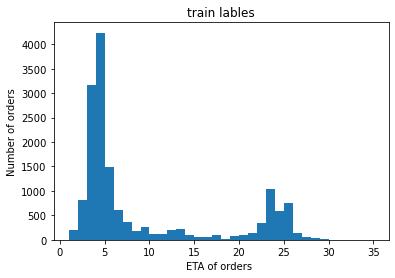

In [27]:

train_label=np.array(train['label']/24)

##观察下预测结果的分布
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("最长时间:%s day"%(np.max(train_label)))
print("最短时间:%s day"%np.min(train_label))
print("平均时间:%s day"%np.mean(train_label))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(train_label)),int(max(train_label)),int(max(train_label)))
plt.hist(train_label,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.title('train lables')
plt.show()

## 观察下测试集中给了多少天的轨迹数据
- 最长时间:16.88171296296296 day
- 最短时间:0.046527777777777786 day
- 平均时间:4.325498415081749 day

最长时间:16.88171296296296 day
最短时间:0.0 day
平均时间:1.8645530179761354 day


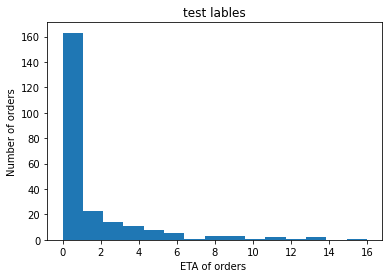

In [28]:
#观察下测试集中给了多少天的轨迹数据
test_label=np.array(test['label']/24)
##观察下预测结果的分布
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("最长时间:%s day"%(np.max(test_label)))
print("最短时间:%s day"%np.min(test_label))
print("平均时间:%s day"%np.mean(test_label))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(test_label)),int(max(test_label)),int(max(test_label)))
plt.hist(test_label,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.title('test lables')
plt.show()

## 搭建训练模型

## xgb+lgb

In [29]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
#from featexp import get_univariate_plots#用于特征筛选，需要先安装featexp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [30]:
#把承运商的名称映射到数值类型
#测试集中出现了149条船，里面有63条没有在训练集里面出现
obj_f=pd.concat((train['vesselMMSI'],test['vesselMMSI'])).reset_index(drop=False)#.unique
class_map={label:idx for idx,label in enumerate(obj_f['vesselMMSI'].unique())}
train['vesselMMSI']=train['vesselMMSI'].map(class_map)
test['vesselMMSI']=test['vesselMMSI'].map(class_map)
#
#把承运商的名称映射到数值类型
#测试集中出现了149条船，里面有63条没有在训练集里面出现
obj_f=pd.concat((train['carrierName'],test['carrierName'])).reset_index(drop=False)#.unique
class_map={label:idx for idx,label in enumerate(obj_f['carrierName'].unique())}
train['carrierName']=train['carrierName'].map(class_map)
test['carrierName']=test['carrierName'].map(class_map)

In [49]:
#trainb1=pd.read_csv('8745train.csv')
#train=pd.concat((train,trainb1)).reset_index(drop=True)
train

,k_1_4,k_3_4,k_median,anchor_cnt,anchor_ratio,lat_1_4,lat_3_4,lat_max,lat_min,lat_median,...,dis_sqrt,year,month,dir_k,vesselMMSI,carrierName,stopTime,cal_dis,cut_label,label
0,-0.562500,0.052083,0.000,0,0.000000,22.156250,22.175781,22.328125,22.046875,22.156250,...,218.899360,2019,1,0.014920,0,0,0.0,322.086846,9.486111,601.755556
1,NaN,NaN,-0.250,3,0.032967,22.406250,22.437500,22.484375,22.406250,22.421875,...,224.338599,2019,1,0.015255,0,0,0.0,19.984359,6.930278,582.217222
2,NaN,0.000000,-0.250,0,0.000000,22.156250,22.265625,22.406250,22.046875,22.156250,...,218.838047,2019,1,0.015281,0,0,0.0,328.730033,9.970556,602.173611
3,-inf,0.000000,-0.625,0,0.000000,22.156250,22.230469,22.546875,22.046875,22.156250,...,218.715257,2019,1,0.015933,0,0,0.0,216.805866,7.225556,603.028611
4,0.121528,inf,inf,130,0.109060,22.484375,30.468750,30.500000,22.046875,24.265625,...,219.209113,2019,1,0.014043,0,0,0.0,1200.760383,133.703889,600.772222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24383,NaN,0.000000,NaN,0,0.000000,22.296875,22.343750,22.359375,22.265625,22.343750,...,23.600595,2019,11,1.968841,38,4,0.0,15.515691,0.836389,144.657778
24384,NaN,0.000000,NaN,0,0.000000,22.296875,22.343750,22.359375,22.265625,22.343750,...,23.575965,2019,11,2.025356,38,4,0.0,15.515691,0.836389,122.232778
24385,-inf,-inf,-inf,0,0.000000,22.109375,22.218750,22.250000,22.093750,22.140625,...,23.574117,2019,11,1.937410,38,4,0.0,25.948508,1.338333,143.756389
24386,-inf,-inf,-inf,0,0.000000,22.109375,22.218750,22.250000,22.093750,22.140625,...,23.547744,2019,11,1.992511,38,4,0.0,25.948508,1.338333,121.331389


In [32]:
#train.to_csv('15643train.csv',index=False)

In [73]:
#
features =['k_1_4','k_3_4','k_median','anchor_ratio','lat_1_4','lat_3_4','lat_max','lat_min'
    ,'lat_median','lat_mean','lon_1_4','lon_3_4','lon_max','lon_min','lon_median','lon_mean'
    'speed_1_4','speed_3_4','speed_min','speed_max','speed_median','speed_mean','direction_1_4','direction_3_4','direction_max'
    ,'direction_min','direction_median','direction_mean','sx','sy','ex','ey'
    ,'dis','lon_dis','lat_dis','cal_speed','month','dir_k','carrierName']
train_data=train[features]
test_data=test[features]
y=train['label']
train_data.shape,test_data.shape

((24388, 38), (239, 38))

In [51]:
features=['sx',  'sy', 'anchor_ratio',
       'lat_mean', 'lat_3_4','lat_max','speed_median', 'k_median',
       'lat_1_4', 'speed_3_4', 'lat_min', 'speed_max', 'carrierName', 'speed_mean', 'direction_mean',
       'month', 'lon_dis', 'direction_1_4', 'lat_dis', 'dis',
       'direction_min', 'direction_3_4', 'direction_median', 'cal_speed',
       'dir_k', 'direction_max', 'ex', 'ey','cal_dis','cut_label',]
train_data=train[features]
test_data=test[features]
y=train['label']
train_data.shape,test_data.shape



((24388, 30), (239, 30))

In [74]:
x_train,x_test,y_train,y_test=train_test_split(train_data,y,test_size=0.1,random_state=2020)

In [75]:
x_train.shape,x_test.shape

((21949, 38), (2439, 38))

In [76]:
llf= lgb.LGBMRegressor(objective='regression',
                        num_leaves=21,
                        learning_rate=0.05,
                        n_estimators=3000,
                        random_state=2020)

llf.fit(x_train,y_train)

llf_val_mse=mean_squared_error(y_test,llf.predict(x_test))
llf_train_mse=mean_squared_error(y_train,llf.predict(x_train))
print('val_mse:','{:e}'.format(llf_val_mse))
print('train_mse:','{:e}'.format(llf_train_mse))

val_mse: 1.722459e+02
train_mse: 2.024195e+01


In [77]:
details=[]
answers=np.zeros(len(test))
n_splits=5
cnt=0
mean_error=0
sk=KFold(n_splits=n_splits,shuffle=True,random_state=2020)
for train_k,test_k in sk.split(train_data,y):
    cnt+=1
    x_train=train_data.iloc[train_k]
    y_train=y.iloc[train_k]
    x_test=train_data.iloc[test_k]
    y_test=y.iloc[test_k]
    llf.fit(x_train,y_train)
    error=mean_squared_error(y_test,llf.predict(x_test))
    print("第%d次验证mse误差为%f" %(cnt,error))
    mean_error+=error/n_splits
    test_lgb=llf.predict(test_data)
    answers+=test_lgb/n_splits
print("平均验证误差%f"%mean_error)

第1次验证mse误差为183.469001
第2次验证mse误差为145.732643
第3次验证mse误差为194.329470
第4次验证mse误差为246.482778
第5次验证mse误差为169.051187
平均验证误差187.813016


## 观察训练/验证过程

## 观察预测结果的分布

预测的最长时间:34.192031224648474 day
预测的最短时间:1.6187471319076578 day
预测的平均时间:12.44649907964705 day


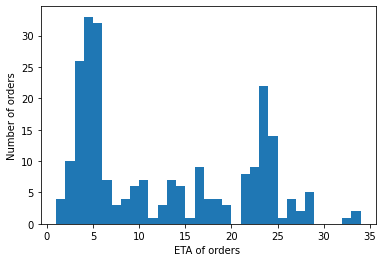

In [78]:
##观察下预测结果的分布
re_day=answers/24
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("预测的最长时间:%s day"%(np.max(re_day)))
print("预测的最短时间:%s day"%np.min(re_day))
print("预测的平均时间:%s day"%np.mean(re_day))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(re_day)),int(max(re_day)),int(max(re_day)))
plt.hist(re_day,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.show()
plt.close()

预测的最长时间:35.13816358024692 day
预测的最短时间:1.3967475229318103 day
预测的平均时间:12.274253502963509 day


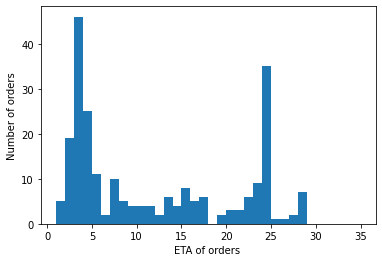

In [79]:
##观察下ans6k结果的分布
ansb_8_9dw=np.load('../submit/b_8_9dw.npy')
re_day=ansb_8_9dw/24
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("预测的最长时间:%s day"%(np.max(re_day)))
print("预测的最短时间:%s day"%np.min(re_day))
print("预测的平均时间:%s day"%np.mean(re_day))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(re_day)),int(max(re_day)),int(max(re_day)))
plt.hist(re_day,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.show()
plt.close()

In [82]:
#
def weight_mse(data1,data2):
    weights=cut_df['cut_point'].values
    weights=weights/np.sum(weights)
    mse=0
    for i in range(len(data1)):
        mse+=weights[i]*(data1[i]-data2[i])**2
    return mse
final_ronghe_b=np.load('../submit/final_ronghe_b_fusai.npy')
ansqyl_mse1100=np.load('../submit/qyl_mse1100.npy')
ans_1075=np.load('../submit/best1075.npy')
ansb_rxd1421=np.load('../submit/pre_rxd_zw_mse1421.npy')
ansb_rxd1471=np.load('../submit/pre_rxd_zw_mse1471.npy')
print("answer与ansb_8_9dw的mse:%.0f,加权mse:%.0f"%(mean_squared_error(answers,final_ronghe_b),weight_mse(answers,final_ronghe_b)))
print("answer与ans_1075的mse:%.0f,加权mse:%.0f"%(mean_squared_error(final_ronghe_b,ans_1075),weight_mse(final_ronghe_b,ans_1075)))
print("answer与ansqyl_mse1100的mse:%.0f,加权mse:%.0f"%(mean_squared_error(answers,ansqyl_mse1100),weight_mse(answers,ansqyl_mse1100)))
print("answers与ansb_rxd1421的mse:%.0f,加权mse:%.0f"%(mean_squared_error(answers,ansb_rxd1421),weight_mse(answers,ansb_rxd1421)))
print("answers与ansb_rxd1471的mse:%.0f,加权mse:%.0f"%(mean_squared_error(answers,ansb_rxd1471),weight_mse(answers,ansb_rxd1471)))

answer与ansb_8_9dw的mse:504,加权mse:579
answer与ans_1075的mse:251,加权mse:438
answer与ansqyl_mse1100的mse:788,加权mse:1159
answers与ansb_rxd1421的mse:1136,加权mse:1071
answers与ansb_rxd1471的mse:1036,加权mse:973


In [59]:
ronghe=np.load('../submit/ronghe_1_fusai_b.npy')
print("ronghe与ansb_8_9dw的mse:%.0f,加权mse:%.0f"%(mean_squared_error(ronghe,ansb_8_9dw),weight_mse(ronghe,ansb_8_9dw)))
print("answers与ronghe的mse:%.0f,加权mse:%.0f"%(mean_squared_error(answers,ronghe),weight_mse(answers,ronghe)))
print("answers与ansb_rxd1471的mse:%.0f,加权mse:%.0f"%(mean_squared_error(answers,ansb_rxd1471),weight_mse(answers,ansb_rxd1471)))

ronghe与ansb_8_9dw的mse:182,加权mse:171
answers与ronghe的mse:537,加权mse:662
answers与ansb_rxd1471的mse:1047,加权mse:1007


SZ109188860665 1.0
NH240192470616 3.0
JB123387157454 3.0
ZO975754571124 3.0
DH829189593918 105.0
86 105.0
LE381377964668 68.0
95 68.0
ZX552539758501 1.0
TB846768731403 4.0
HQ193237808500 1.0
QK696918637480 8.0

In [60]:
answers[177],ansb_8_9dw[177]

(803.285666235279, 843.315925925926)

In [61]:
answers[177],ansb_8_9dw[177]

(803.285666235279, 843.315925925926)

In [62]:
tmp=abs(answers-ans_1075)
for i in range(len(tmp)):
    if tmp[i]>100:
        print(tmp[i],i)

111.19881108436431 8
154.82015668768602 60


In [63]:
answers[5],ansb_8_9dw[5],ansb_rxd1421[5],ansb_rxd1471[5]

(408.6223052375692, 285.57, 371.89444444444445, 475.90444444444444)

In [64]:
answers[110],ansb_8_9dw[110],ansb_rxd1421[110],ansb_rxd1471[110]

(155.5038225966607, 197.51916666666665, 86.61861111111111, 114.9325)

In [65]:
def get_name(ids):
    grouped=df_test.groupby('loadingOrder',sort=False)
    cnt=0
    for name,group in grouped:
        if cnt==ids:
            print(name)
        cnt+=1
def get_max_mse(data1,data2,data3,data4):
    var_list=[]
    for i in range(len(data1)):
        a=np.array([data1[i],data2[i],data3[i],data4[i]])
        var_list.append(a.var())
        if a.var()>2000:
            get_name(i)
        #print(a.var())
    return var_list
var_list=get_max_mse(answers,ansb_8_9dw,ansb_rxd1421,ansb_rxd1471)

FQ684650477699
WG447072368140
TG217980286566
UU855384397170
GN475000708758
MF280195890024
PP362007425226
SX487073652239
CW302926509424


In [134]:
grouped=df_test.groupby('loadingOrder',sort=False)
cnt=0
for name,group in grouped:
    if cnt==60:
        print(name)
    cnt+=1

GN475000708758


GN475000708758
IE114789474106

## 特征重要度筛选

<Figure size 1296x648 with 0 Axes>

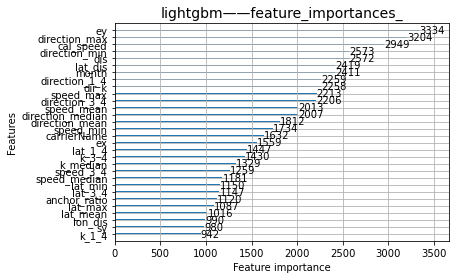

In [66]:
plt.figure(figsize=(18,9))
lgb.plot_importance(llf,max_num_features=30)
plt.title('lightgbm——feature_importances_',fontsize=14)
plt.show()

In [53]:
importance=pd.DataFrame({
        'column': train_data.columns,
        'importance': llf.booster_.feature_importance(),
    }).sort_values(by='importance')
importance=importance.reset_index(drop=True)
importance['column'].values#[0:]

array(['sx', 'lon_min', 'lon_median', 'lon_1_4', 'sy', 'anchor_ratio',
       'lat_mean', 'lat_median', 'lon_max', 'lon_3_4', 'lat_3_4', 'k_1_4',
       'lat_max', 'lon_meanspeed_1_4', 'speed_median', 'k_median',
       'lat_1_4', 'k_3_4', 'speed_3_4', 'lat_min', 'speed_min',
       'speed_max', 'carrierName', 'speed_mean', 'direction_mean',
       'month', 'lon_dis', 'direction_1_4', 'lat_dis', 'dis',
       'direction_min', 'direction_3_4', 'direction_median', 'cal_speed',
       'dir_k', 'direction_max', 'ex', 'ey'], dtype=object)

## 生成提交文件

DH829189593918 105.0
24 105.0
LE381377964668 68.0
87,68.0

In [68]:
test['label'] = answers
result=test[['loadingOrder', 'label']]
test_data_path = '../Btest0711_ALL.csv'
test_data=pd.read_csv(test_data_path)
test_data=get_data(test_data, mode='test')
#
test_data = test_data.merge(result, on='loadingOrder', how='left')
test_data['ETA'] = (test_data['onboardDate'] + test_data['label'].apply(lambda x:pd.Timedelta(hours=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data.drop(['direction','TRANSPORT_TRACE'],axis=1,inplace=True)
test_data['onboardDate'] = test_data['onboardDate'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
test_data['timestamp'] = test_data['temp_timestamp']
# 整理columns顺序
submit = test_data[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

In [69]:
submit[submit['loadingOrder'].isin(['WG447072368140'])]#FA712454830300

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
730,WG447072368140,2020-06-01T00:00:12.000Z,14.499490,-22.893365,RWHZVZ,V6234300528,2020/06/01 00:00:00,2020/06/18 00:37:20,2020/08/10 10:22:46
731,WG447072368140,2020-06-01T00:02:12.000Z,14.499735,-22.888367,RWHZVZ,V6234300528,2020/06/01 00:00:00,2020/06/18 00:37:20,2020/08/10 10:22:46
732,WG447072368140,2020-06-01T00:04:12.000Z,14.499978,-22.883375,RWHZVZ,V6234300528,2020/06/01 00:00:00,2020/06/18 00:37:20,2020/08/10 10:22:46
733,WG447072368140,2020-06-01T00:06:12.000Z,14.500322,-22.878165,RWHZVZ,V6234300528,2020/06/01 00:00:00,2020/06/18 00:37:20,2020/08/10 10:22:46
734,WG447072368140,2020-06-01T00:08:04.000Z,14.500562,-22.873402,RWHZVZ,V6234300528,2020/06/01 00:00:00,2020/06/18 00:37:20,2020/08/10 10:22:46
...,...,...,...,...,...,...,...,...,...
1268,WG447072368140,2020-06-01T23:38:26.000Z,10.544117,-17.109868,RWHZVZ,V6234300528,2020/06/01 00:00:00,2020/06/18 00:37:20,2020/08/10 10:22:46
1269,WG447072368140,2020-06-01T23:42:51.000Z,10.531592,-17.092637,RWHZVZ,V6234300528,2020/06/01 00:00:00,2020/06/18 00:37:20,2020/08/10 10:22:46
1270,WG447072368140,2020-06-01T23:55:00.000Z,10.498785,-17.043038,RWHZVZ,V6234300528,2020/06/01 00:00:00,2020/06/18 00:37:20,2020/08/10 10:22:46
1271,WG447072368140,2020-06-01T23:59:30.000Z,10.487412,-17.024637,RWHZVZ,V6234300528,2020/06/01 00:00:00,2020/06/18 00:37:20,2020/08/10 10:22:46


In [70]:
submit.to_csv('../submit/qyl_mse650.csv', index=False)

In [71]:
np.save('../submit/qyl_mse650.npy',answers)

In [72]:
answers[60]

85.52517731231399